In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
X_train = pd.read_csv('data/input/non_standardized_X_train.csv', index_col=0)
y_train = pd.read_csv('data/input/y_log_train.csv', index_col=0)

In [3]:
X_test = pd.read_csv('data/input/non_standardized_X_test.csv', index_col=0)

In [4]:
np.random.seed(42)

### 10-fold Cross-Validation

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [6]:
def kfold_mse(X, y, model, k=10):
    kf = KFold(n_splits=k)
    mses = []
    for i, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_train, y_train['sales']) # Avoid deprecation warning
        y_pred = model.predict(X_val)
        mses.append(mean_squared_error(np.exp(y_pred), np.exp(y_val['sales']))) # Have to exponentiate to get back to original scale
    return mses

Since scikit-learn's implementation of random forest has many tunable hyperparameters, we shall concern only `ccp_alpha` in this project. `n_estimators`, `max_features`, `min_samples_split` are fixed to 1000, 'sqrt' and 0.01. Actually, using more estimators is better as random forest does not overfit. 1000 is a good number to stay within computational time limits.

In [7]:
ccp_alphas = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 1.0]

In [8]:
from sklearn.ensemble import RandomForestRegressor

In [9]:
best_mses = []
best_avg_score = 1e9
best_ccp_alpha = None
for ccp_alpha in ccp_alphas:
    model = RandomForestRegressor(min_samples_split=0.01, ccp_alpha=ccp_alpha, n_estimators=1000, max_features='sqrt', random_state=42)
    mses = kfold_mse(X_train, y_train, model)
    if np.mean(mses) < best_avg_score:
        best_avg_score = np.mean(mses)
        best_ccp_alpha = ccp_alpha
        best_mses = mses
    print(f'ccp_alpha: {ccp_alpha}, avg_mse: {np.mean(mses)}')

ccp_alpha: 0.005, avg_mse: 512.4132828969017
ccp_alpha: 0.01, avg_mse: 551.4190914427995
ccp_alpha: 0.02, avg_mse: 592.9229836754206
ccp_alpha: 0.03, avg_mse: 619.071326201157
ccp_alpha: 0.04, avg_mse: 639.5631542733374
ccp_alpha: 0.05, avg_mse: 655.8917665643901
ccp_alpha: 0.1, avg_mse: 713.334751013909
ccp_alpha: 0.5, avg_mse: 822.6627690510064
ccp_alpha: 1.0, avg_mse: 834.2701676872451


### In-sample analysis

In [10]:
cv_df = pd.DataFrame(best_mses, columns=['Cross-Validation MSE'])
cv_df

,Cross-Validation MSE
0,553.325864
1,308.752847
2,533.965203
3,388.327182
4,511.375772
5,215.541213
6,808.988448
7,485.818856
8,1166.630069
9,151.407375


In [11]:
cv_df.to_csv('data/output/cv/rf_log.csv')

### Model fitting

After finding best parameters (not applicable to LR but useful for other models), we fit the model on the entire training set and predict on the test set. Also, we collect residuals to prepare for inventory decision making.

In [12]:
rf = RandomForestRegressor(min_samples_split=0.01, ccp_alpha=best_ccp_alpha, n_estimators=1000, max_features='sqrt', random_state=42)
rf.fit(X_train, y_train['sales']) # Avoid deprecation warning
residuals = np.exp(y_train['sales']) - np.exp(rf.predict(X_train)) # Have to exponentiate to get back to original scale

In [13]:
output_df = X_test.copy()

In [14]:
output_df['sales'] = np.exp(rf.predict(X_test)) # Have to exponentiate to get back to original scale

### Inventory decision
As sales data come from a natural process, we shall not assume it is distributed in any particular model. Hence, we shall use an empirical distribution to make our inventory decision. 

In [15]:
residuals.describe()

count    2211.000000
mean        5.539475
std        21.342480
min       -19.989854
25%        -1.837149
50%         0.121019
75%         4.740689
max       434.341934
Name: sales, dtype: float64

For visualization of Empirical CDF, we use the `statsmodels` package:

In [16]:
from statsmodels.distributions.empirical_distribution import ECDF

In [17]:
ecdf = ECDF(residuals)

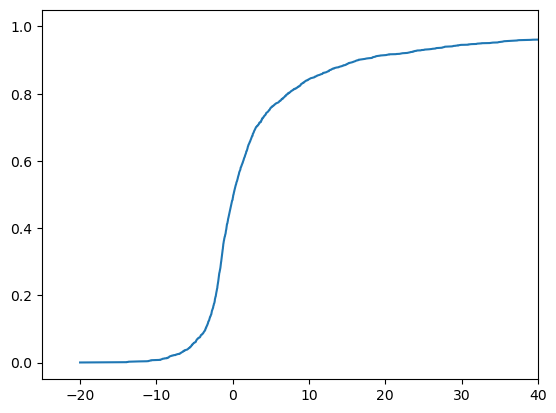

In [18]:
plt.plot(ecdf.x, ecdf.y)
plt.xlim(-25, 40)
plt.show()

Sparsity is not a concern since we have a large sample size. Therefore, we can use interpolation to obtain ppf. To get the empirical ppf, we can use scipy's `interp1d` to get the inverse function:

In [19]:
from scipy.interpolate import interp1d

In [20]:
eppf = interp1d(ecdf.y, ecdf.x)

Calculate the critical fractile

In [21]:
price = 20
cost = 12
salvage = 8
over = cost - salvage
under = price - cost
critical_fractile = under / (over + under)
critical_fractile

0.6666666666666666

We offset our predictions for the test datasets by the $eppf(critical\_fractile)$ to get the optimal inventory level.

In [22]:
output_df['inventory'] = eppf(critical_fractile) + output_df['sales']

In [23]:
output_df[['sales', 'inventory']].head()

,sales,inventory
0,24.637920,27.071941
1,38.536190,40.970211
2,13.880561,16.314582
3,20.694170,23.128191
4,8.167321,10.601342


In [24]:
output_df.to_csv('data/output/predictions/rf_log.csv')